In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [50]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

In [ ]:
def set_axis(x, no_labels=7) -> tuple:
    """Helper function for setting plot axis ticks"""
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0, nx, step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels


def plot_range(ts_start: str, ts_end: str):
    """Plot raw data for a time range"""
    pack = get_range(ts_start, ts_end)
    df = pack["df"]

    df = df - df.mean()
    df = np.abs(df)

    low, high = np.percentile(df, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)

    fig = plt.figure(figsize=(12, 16))
    ax = plt.axes()

    im = ax.imshow(df, aspect='auto', interpolation='none', norm=norm)
    ax.set_ylabel("time")
    ax.set_xlabel("space [m]")

    cax = fig.add_axes([
        ax.get_position().x1 + 0.06,
        ax.get_position().y0,
        0.02,
        ax.get_position().height
    ])
    plt.colorbar(im, cax=cax)

    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))

    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)

    plt.show()
    
def plot_fft(freqs, fft_magnitudes, channels=None, max_freq=None):
    """Plot frequency spectrum for selected channels"""
    n_channels = fft_magnitudes.shape[1]
    
    if channels is None:
        channels = range(min(5, n_channels))
    
    plt.figure(figsize=(12, 6))
    for ch in channels:
        mag = fft_magnitudes[:, ch]
        pos_mask = freqs >= 0
        if max_freq:
            pos_mask = pos_mask & (freqs <= max_freq)
        plt.plot(freqs[pos_mask], mag[pos_mask], label=f'Channel {ch}', alpha=0.7)
    
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title('Frequency Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
def plot_moving_objects(data, dt, dx):
    """Visualize extracted moving objects"""
    low, high = np.percentile(np.abs(data), [1, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 16))
    im = ax.imshow(np.abs(data), aspect='auto', interpolation='none', 
                   cmap='viridis', norm=norm)
    plt.colorbar(im, ax=ax, label='Amplitude')
    ax.set_xlabel('Space [m]')
    ax.set_ylabel('Time')
    ax.set_title('Moving Objects')
    plt.show()

def plot_detected_objects(data, detected_objects, dt, dx, ts_start, ts_end):
    """Plot data with detected object trajectories overlaid"""
    n_time, n_space = data.shape
    
    low, high = np.percentile(np.abs(data), [1, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    fig, ax = plt.subplots(figsize=(14, 16))
    im = ax.imshow(np.abs(data), aspect='auto', interpolation='none', 
                   norm=norm, cmap='viridis', alpha=0.8)
    
    if detected_objects:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(detected_objects)))
        
        for obj, color in zip(detected_objects, colors):
            velocity = obj['velocity']
            obj_id = obj['object_id']
            
            if velocity != 0:
                slope_pixels = (dx / velocity) / dt
                x_pixels = np.array([0, n_space - 1])
                y_pixels_norm = slope_pixels * x_pixels * dx / dt
                
                if y_pixels_norm[1] > 0 and y_pixels_norm[0] < n_time:
                    ax.plot(x_pixels, y_pixels_norm, 
                           color=color, linewidth=2, alpha=0.7,
                           label=f'Obj {obj_id}: v={velocity:.1f} m/s ({velocity*3.6:.1f} km/h)')
    
    ax.set_xlabel('Space [channels]')
    ax.set_ylabel('Time [samples]')
    ax.set_title(f'Detected Objects: {ts_start} - {ts_end}')
    
    cax = fig.add_axes([
        ax.get_position().x1 + 0.02,
        ax.get_position().y0,
        0.02,
        ax.get_position().height
    ])
    plt.colorbar(im, cax=cax, label='Amplitude')
    
    if detected_objects:
        ax.legend(loc='upper left', fontsize=8, framealpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDetected {len(detected_objects)} objects:")
    for obj in detected_objects:
        print(f"  Object {obj['object_id']}: "
              f"velocity={obj['velocity']:.2f} m/s ({obj['velocity']*3.6:.1f} km/h)")

def plot_velocities_on_original(ts_start, ts_end, detected_objects, dt, dx):
    """Plot original data with velocity lines and labels"""
    pack = get_range(ts_start, ts_end)
    df = pack["df"]
    
    # Process for visualization
    df_vis = df - df.mean()
    df_vis = np.abs(df_vis)
    
    low, high = np.percentile(df_vis, [3, 99])
    norm = Normalize(vmin=low, vmax=high, clip=True)
    
    n_time, n_space = df_vis.shape
    
    fig, ax = plt.subplots(figsize=(14, 16))
    im = ax.imshow(df_vis.values, aspect='auto', interpolation='none', 
                   norm=norm, cmap='viridis')
    
    if detected_objects:
        # Draw velocity lines
        for obj in detected_objects:
            velocity = obj['velocity']
            
            if velocity != 0:
                # Calculate slope: time per unit space
                # velocity [m/s], so time to travel dx is dx/velocity
                slope_pixels = (dx / velocity) / dt
                
                # Draw line from left to right
                x_pixels = np.array([0, n_space - 1])
                y_pixels = slope_pixels * x_pixels * dx / dt
                
                # Check if line intersects the visible area
                if y_pixels[1] > 0 and y_pixels[0] < n_time:
                    ax.plot(x_pixels, y_pixels, 'r-', linewidth=2, alpha=0.8)
                    
                    # Add velocity label on the line
                    mid_x = n_space / 2
                    mid_y = slope_pixels * mid_x * dx / dt
                    
                    if 0 <= mid_y < n_time:
                        velocity_kmh = velocity * 3.6  # Convert m/s to km/h
                        ax.text(mid_x, mid_y, f'{velocity_kmh:.2f} km/h', 
                               color='red', fontsize=10, fontweight='bold',
                               bbox=dict(boxstyle='round,pad=0.3', 
                                       facecolor='white', alpha=0.7),
                               ha='center', va='bottom')
    
    # Format axes
    ax.set_xlabel('space [m]')
    ax.set_ylabel('Time')
    ax.set_title(f'{ts_start} - {ts_end}')
    
    # Set ticks
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    
    # Colorbar
    cax = fig.add_axes([
        ax.get_position().x1 + 0.02,
        ax.get_position().y0,
        0.02,
        ax.get_position().height
    ])
    plt.colorbar(im, cax=cax, label='Amplitude')
    
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================================
# STEP 1: LOAD DATA
# ============================================================================

def load_data(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    """Load and concatenate data files for specified time range"""
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    return data, dt, dx


# ============================================================================
# STEP 2: FREQUENCY ANALYSIS
# ============================================================================

def perform_fft(data, dt):
    """Compute FFT independently for each channel"""
    n_samples, n_channels = data.shape
    freqs = fftfreq(n_samples, dt)
    fft_data = fft(data, axis=0)
    fft_magnitudes = np.abs(fft_data)
    
    return freqs, fft_data, fft_magnitudes


# ============================================================================
# STEP 3: NOISE FILTERING AND PREPROCESSING
# ============================================================================

def filter_noise(data, fft_data, freqs, dt, lowcut=1, highcut=100, 
                downsample_factor=2, standardize=False):
    """
    Filter noise using frequency domain filtering
    - Remove frequency components outside [lowcut, highcut]
    - Downsample to reduce data size
    - Optional standardization (disabled by default to preserve correlation)
    """
    n_samples, n_channels = data.shape
    
    # Frequency domain filtering
    freq_mask = (np.abs(freqs) >= lowcut) & (np.abs(freqs) <= highcut)
    fft_filtered = fft_data.copy()
    fft_filtered[~freq_mask, :] = 0
    
    # Convert back to time domain
    data_filtered = np.real(np.fft.ifft(fft_filtered, axis=0))
    
    # Downsample
    if downsample_factor and downsample_factor > 1:
        data_filtered = decimate(data_filtered, downsample_factor, axis=0)
        dt = dt * downsample_factor
    
    # Standardize only if requested (can destroy cross-channel correlation)
    if standardize:
        data_filtered = (data_filtered - np.mean(data_filtered, axis=0)) / (np.std(data_filtered, axis=0) + 1e-10)
    
    return data_filtered, dt


# ============================================================================
# STEP 4: EXTRACT MOVING OBJECTS
# ============================================================================

def extract_moving_objects(data, dt, temporal_window=50):
    """
    Remove static background to isolate moving objects
    Uses temporal median filtering to subtract static components
    """
    # Simple approach: subtract temporal median from each channel
    data_centered = data.copy()
    
    for ch in range(data.shape[1]):
        signal = data[:, ch]
        # Use percentile instead of median for more robust background estimation
        background = np.percentile(signal, 50)
        data_centered[:, ch] = signal - background
    
    return data_centered


# ============================================================================
# STEP 5: DETECT OBJECTS AND ESTIMATE VELOCITIES
# ============================================================================

def detect_objects_and_velocities(data, dt, dx, num_channel_pairs=100, max_lag=500):
    """
    Detect moving objects and estimate velocities using cross-correlation
    between adjacent spatial channels to measure time delay
    """
    from scipy.signal import correlate
    
    n_samples, n_channels = data.shape
    velocities = []
    
    print(f"Analyzing {n_channels} channels with {n_samples} samples")
    print(f"dt={dt:.6f}s, dx={dx:.4f}m")
    
    # Try many channel pairs for better statistics
    channel_step = max(1, n_channels // num_channel_pairs)
    
    for i in range(0, n_channels - 1, channel_step):
        signal1 = data[:, i]
        signal2 = data[:, i + 1]
        
        # Check signal strength
        std1, std2 = np.std(signal1), np.std(signal2)
        if std1 < 1e-6 or std2 < 1e-6:
            continue
        
        # Normalize for correlation
        sig1_norm = (signal1 - np.mean(signal1)) / std1
        sig2_norm = (signal2 - np.mean(signal2)) / std2
        
        # Cross-correlation
        correlation = correlate(sig2_norm, sig1_norm, mode='same')
        
        # Search around center for lag
        center = len(correlation) // 2
        search_start = max(0, center - max_lag)
        search_end = min(len(correlation), center + max_lag)
        search_region = correlation[search_start:search_end]
        
        # Find peak correlation
        abs_corr = np.abs(search_region)
        max_corr_idx = np.argmax(abs_corr)
        max_corr_value = abs_corr[max_corr_idx]
        
        # Require significant correlation
        if max_corr_value > 0.3 * np.max(abs_corr):
            lag = (search_start + max_corr_idx) - center
            
            if lag != 0:
                time_delay = lag * dt
                velocity = dx / abs(time_delay)
                
                # Reasonable velocity range for vehicles
                if 1 <= velocity <= 100:
                    velocities.append(velocity)
    
    print(f"Found {len(velocities)} velocity measurements")
    
    if len(velocities) == 0:
        print("No velocities detected. Possible issues:")
        print("- Signal may be too weak or noisy")
        print("- Try adjusting lowcut/highcut frequency filters")
        print("- Check if data contains moving objects")
        return []
    
    velocities = np.array(velocities)
    print(f"Velocity range: {np.min(velocities):.1f} - {np.max(velocities):.1f} m/s")
    print(f"             : {np.min(velocities)*3.6:.1f} - {np.max(velocities)*3.6:.1f} km/h")
    
    # Use histogram clustering
    hist, bin_edges = np.histogram(velocities, bins=30)
    
    detected_objects = []
    threshold = max(2, len(velocities) * 0.05)  # At least 2 measurements or 5%
    
    for bin_idx in range(len(hist)):
        if hist[bin_idx] >= threshold:
            bin_center = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
            in_bin = (velocities >= bin_edges[bin_idx]) & (velocities < bin_edges[bin_idx + 1])
            bin_vels = velocities[in_bin]
            
            detected_objects.append({
                'object_id': len(detected_objects) + 1,
                'velocity': np.median(bin_vels),
                'frequency': None,
                'magnitude': hist[bin_idx]
            })
    
    print(f"Grouped into {len(detected_objects)} distinct velocity groups")
    
    return detected_objects


# ============================================================================
# MAIN ANALYSIS PIPELINE
# ============================================================================

def analyze_segment(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016,
                   lowcut=1, highcut=100, downsample_factor=2,
                   show_steps=False):
    """
    Complete analysis pipeline following 5 steps:
    1. Load data
    2. Frequency analysis
    3. Noise filtering
    4. Extract moving objects
    5. Detect objects and estimate velocities
    """
    data_filtered, dt_filtered = filter_noise(data_raw, fft_data, freqs, dt, lowcut, highcut, downsample_factor)
    # STEP 1: Load data
    data_raw, dt, dx = load_data(ts_start, ts_end, dx, dt)
    # STEP 4: Extract moving objects
    # STEP 2: Frequency analysis
    
    
    # STEP 3: Noise filtering
    
                                              
    if len(detected_objects) == 0:
    # STEP 4: Extract moving objects
    # Use filtered data (not moving objects) for better correlation
    print("\n=== STEP 5: Detecting objects and velocities ===")
    detected_objects = detect_objects_and_velocities(data_filtered, dt_filtered, dx)
    
    if len(detected_objects) == 0:
    data_moving = extract_moving_objects(data_filtered, dt_filtered)
    
    # STEP 5: Detect objects and estimate velocities
    print("\n=== STEP 5: Detecting objects and velocities ===")
    detected_objects = detect_objects_and_velocities(data_filtered, dt_filtered, dx)
    
    if len(detected_objects) == 0:
        print("\nRetrying with less aggressive filtering...")
        data_light, dt_light = filter_noise(data_raw, fft_data, freqs, dt,
                                            lowcut, highcut, downsample_factor=1)
        detected_objects = detect_objects_and_velocities(data_light, dt_light, dx)
    
    # Optional visualization
    if show_steps:
        print("\nStep 4: Moving objects extracted")
        plot_moving_objects(data_moving, dt_filtered, dx)
        
        print("\nStep 5: Objects detected")
        plot_detected_objects(data_filtered, detected_objects, dt_filtered, dx,
                            ts_start, ts_end)
        
        print("\nVelocities on original data:")
        plot_velocities_on_original(ts_start, ts_end, detected_objects, dt, dx)
    
    return {
        'ts_start': ts_start,
        'ts_end': ts_end,
        'data_raw': data_raw,
        'data_filtered': data_filtered,
        'data_moving': data_moving,        'detected_objects': detected_objects,        'velocities': [obj['velocity'] for obj in detected_objects],        'dt': dt,        'dt_filtered': dt_filtered,        'dx': dx
    }

SyntaxError: invalid syntax. Perhaps you forgot a comma? (863870008.py, line 214)

Analyzing 52 channels with 37500 samples
dt=0.0032, dx=5.1065
Found 0 velocity measurements
No valid velocities found - trying less strict filtering...
No objects detected on moving objects data, trying filtered data...
Analyzing 52 channels with 37500 samples
dt=0.0032, dx=5.1065
Found 0 velocity measurements
No valid velocities found - trying less strict filtering...
Step 4: Moving objects extracted
Found 0 velocity measurements
No valid velocities found - trying less strict filtering...
Step 4: Moving objects extracted


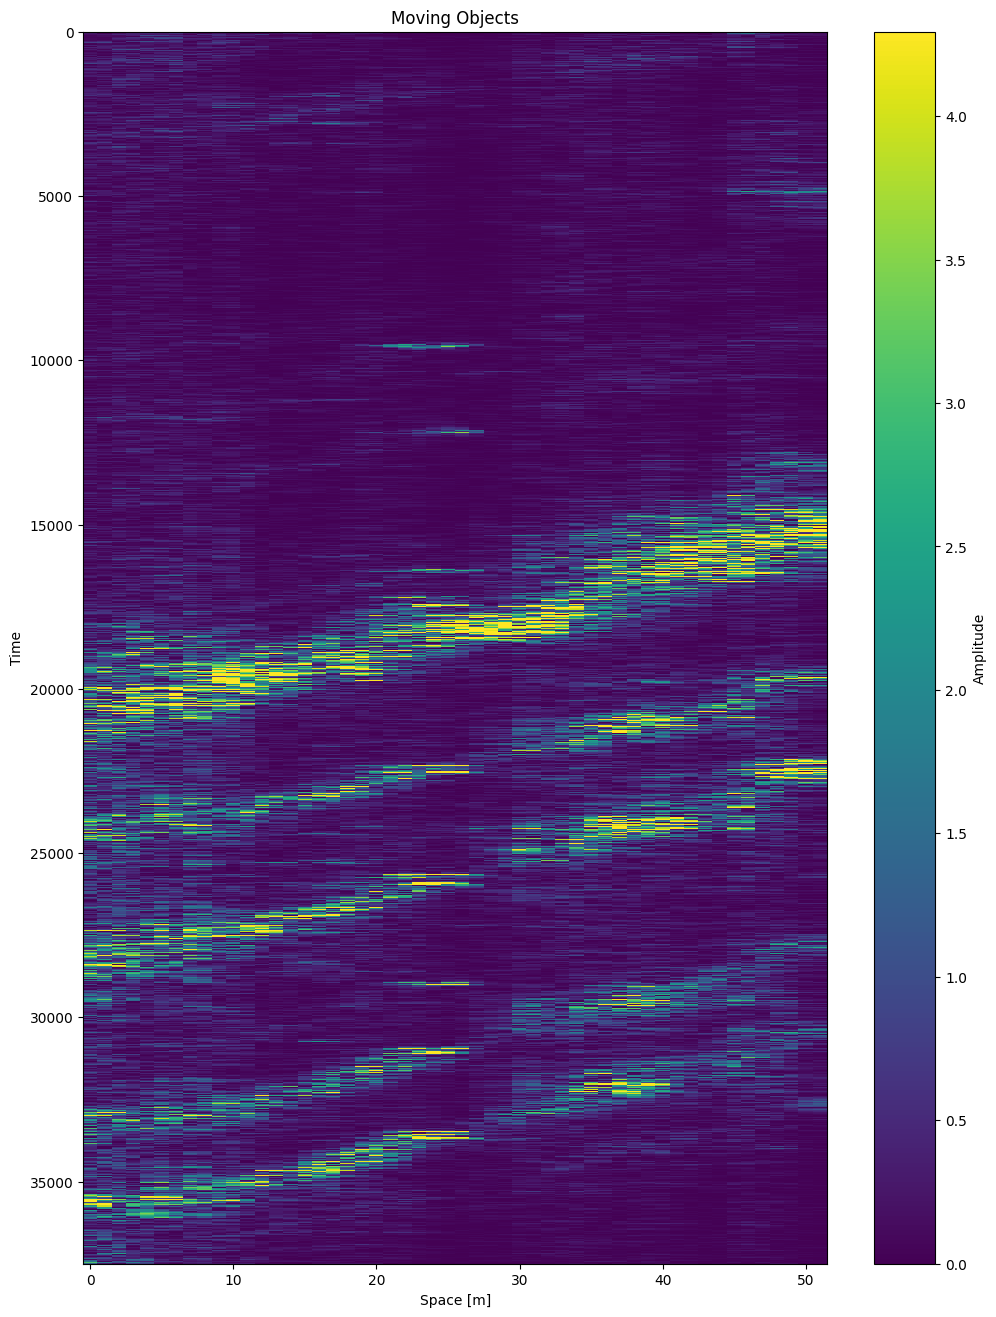

Step 5: Objects detected


C:\Users\Piotrek\AppData\Local\Temp\ipykernel_20492\2858716098.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


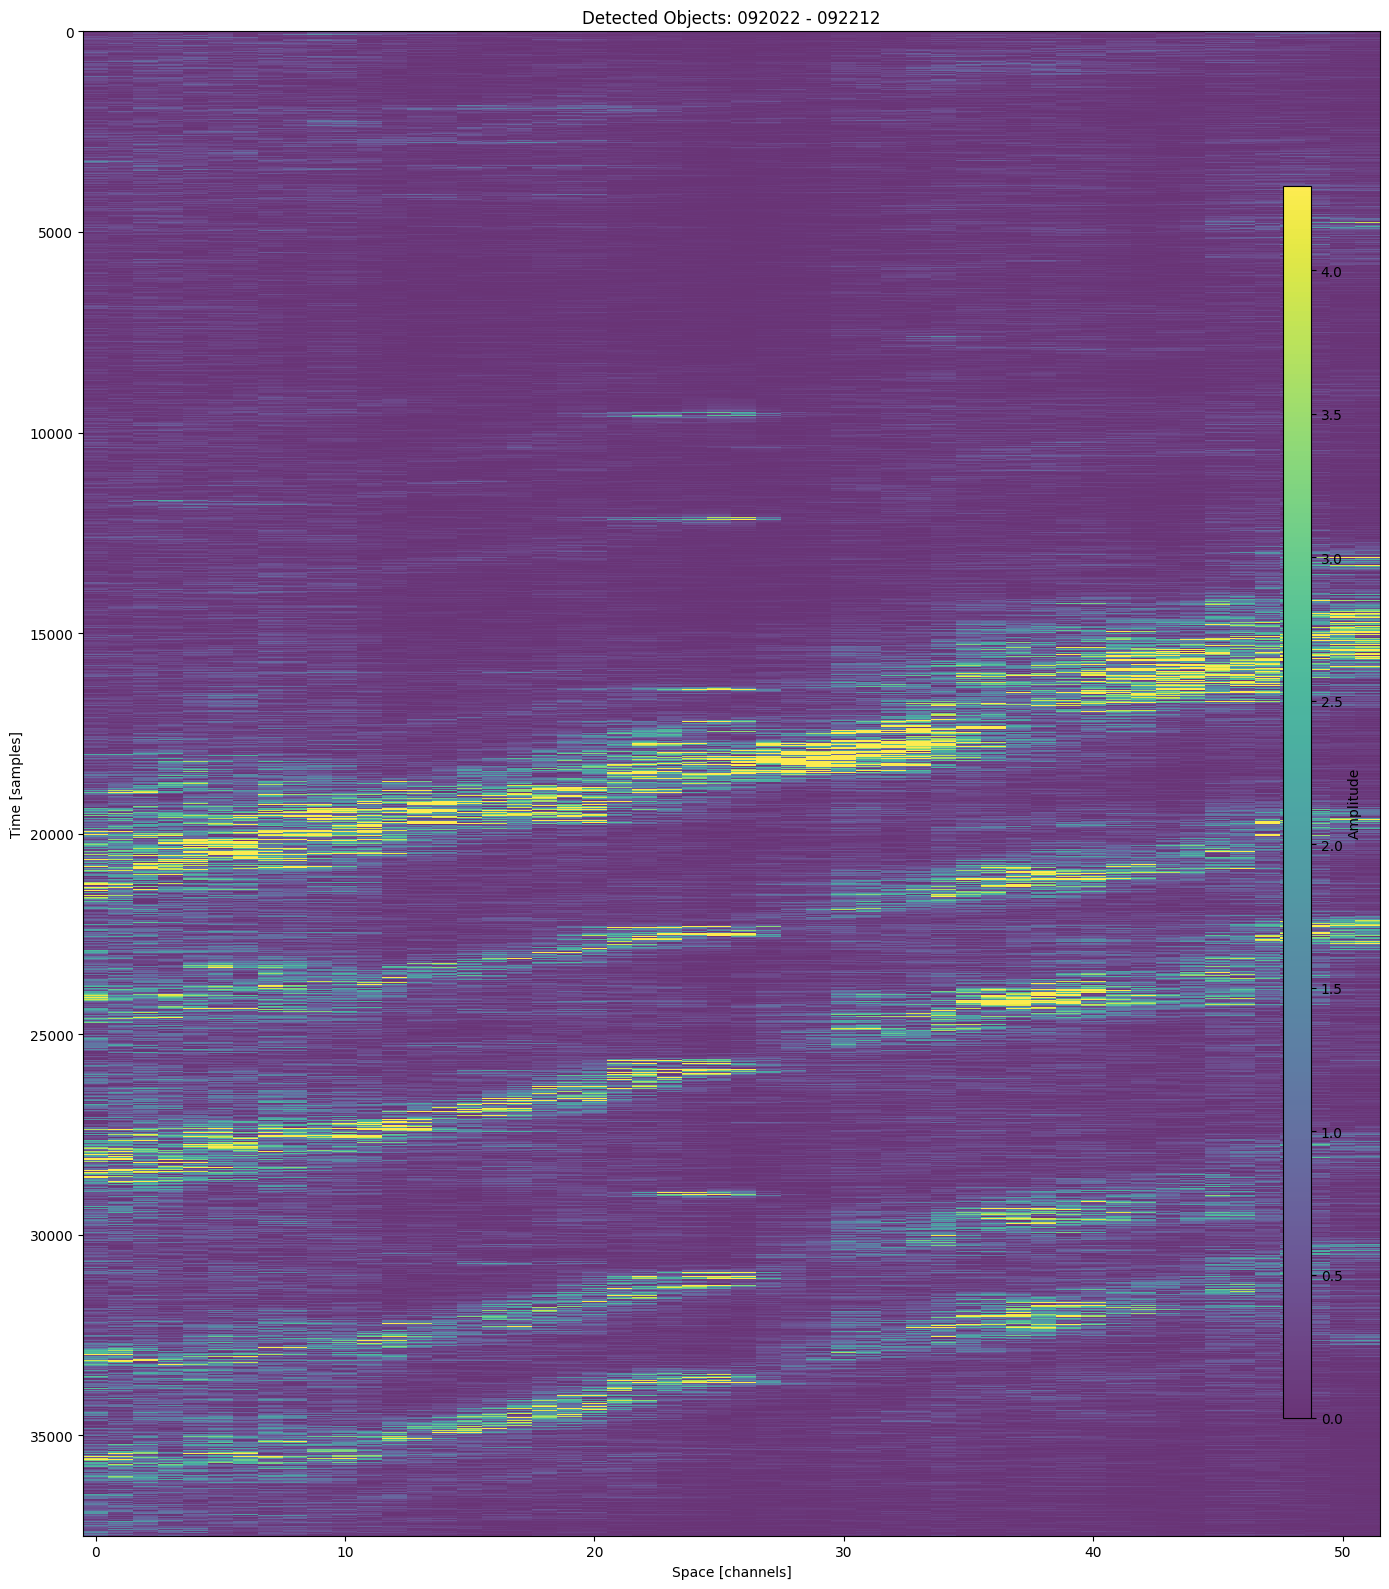


Detected 0 objects:
Velocities on original data:


C:\Users\Piotrek\AppData\Local\Temp\ipykernel_20492\2858716098.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


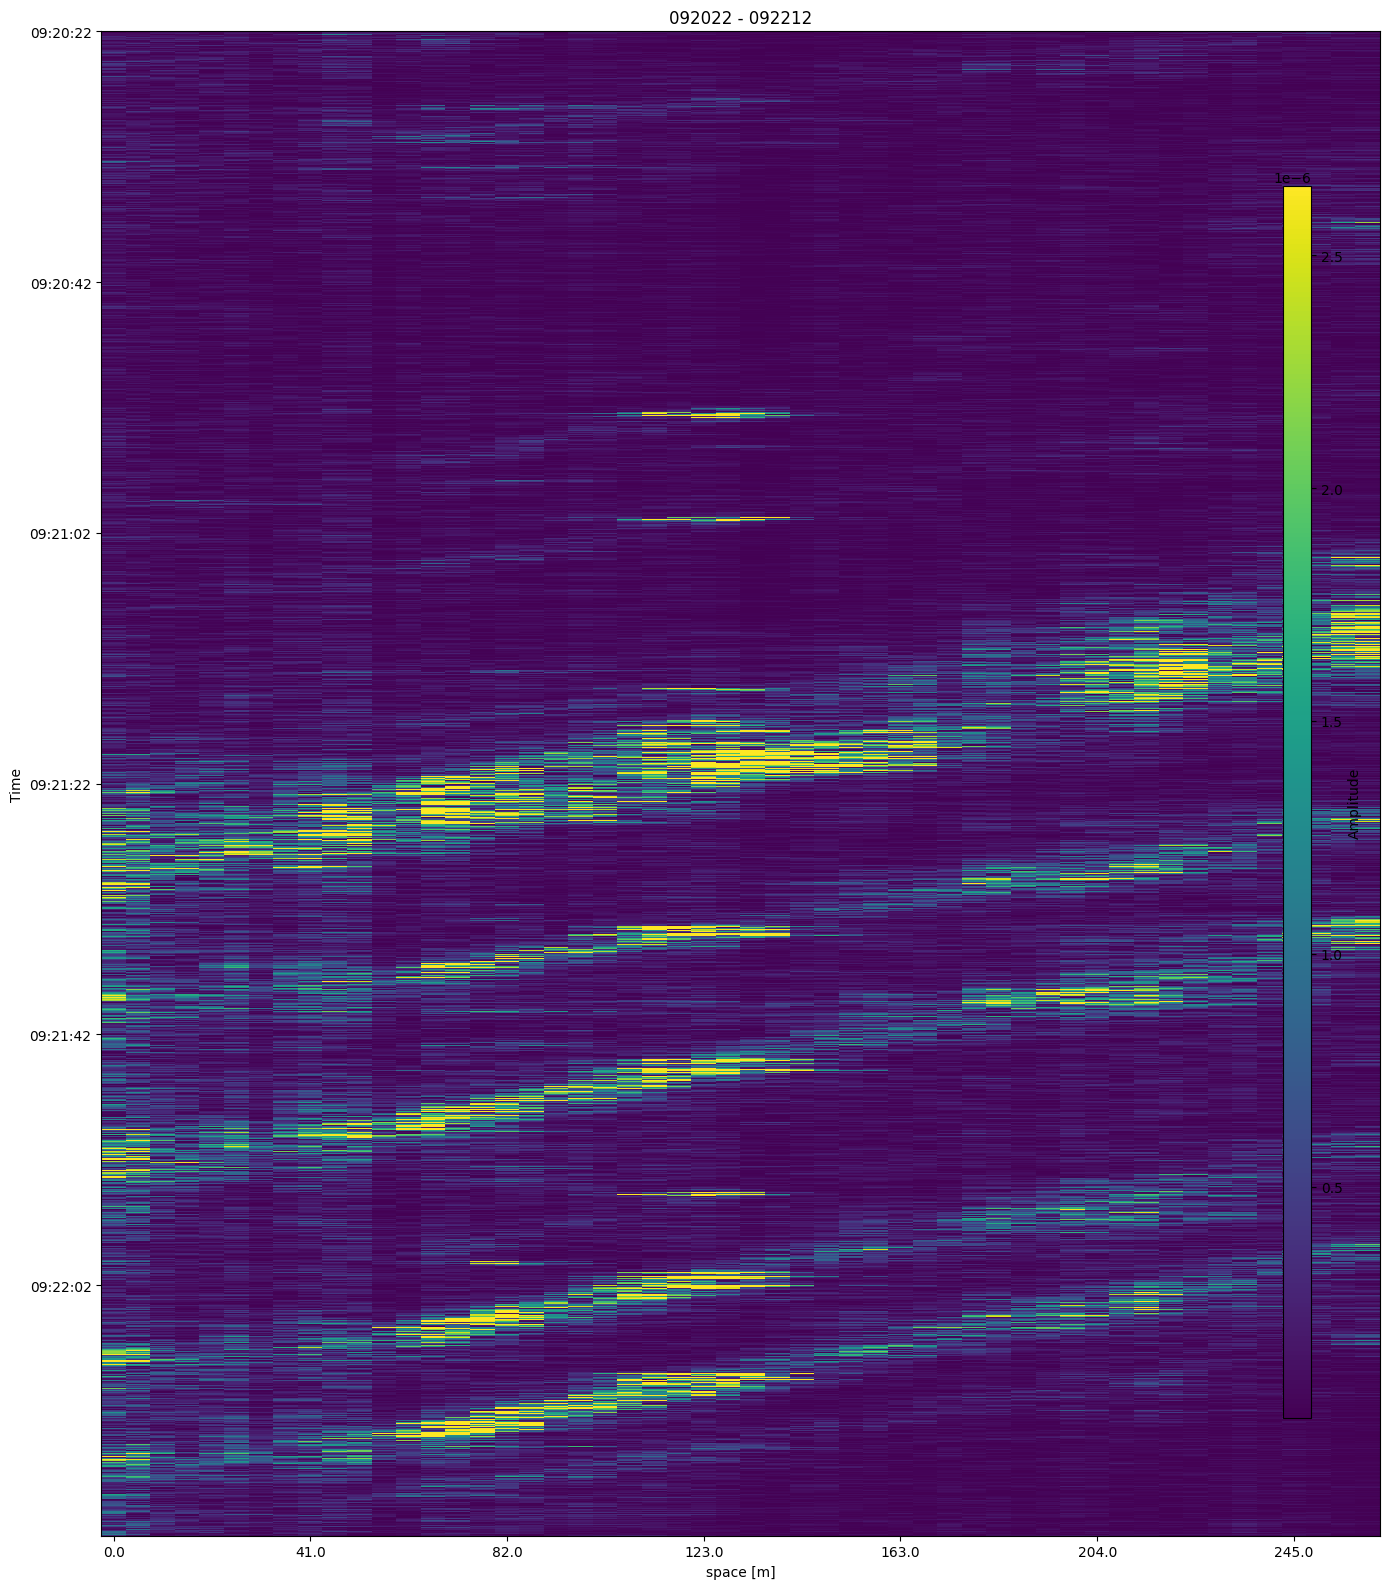


Detected 0 objects
Velocities: []


In [ ]:
# Example usage
result = analyze_segment(range1[0], range1[1], lowcut=1, highcut=100, 
                        downsample_factor=2, show_steps=True)

print(f"\nDetected {len(result['detected_objects'])} objects")
print("Velocities:", [f"{v:.1f} m/s" for v in result['velocities']])
